<a href="https://colab.research.google.com/github/dohun-mat/dna_study_semina/blob/main/week4_%EA%B3%BC%EC%A0%9C_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pwd

'/content'

In [2]:
%cd /content/drive/MyDrive/CV_seminar_project

[Errno 2] No such file or directory: '/content/drive/MyDrive/CV_seminar_project'
/content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [5]:
device

'cuda'

In [6]:
root_path = '/content/drive/MyDrive/Colab Notebooks/dna/original-1'
train_path = '/content/drive/MyDrive/Colab Notebooks/dna/original-1/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/dna/original-1/test'

# pytorch 데이터셋 클래스 실습

### 1. 파이토치 데이터 셋 클래스를 직접 만들어보자.

파이토치 데이터 셋 클래스는 init, getitem, len 특수 메소드 3개를 요구한다.   
 항상 같은 포맷을 만드는 습관이 중요하다. 
> 따라서 root_path, mode(train or validation or test), transform(전처리&Augmentation) 3개의 입력을 받아 data와 label을 출력하는 클래스를 만들도록하자.


In [7]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os 

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms):
    self.all_data = sorted( glob.glob( os.path.join(root_path, mode, '*', '*') ) ) # 전체 경로
    self.transforms = transforms

  def __getitem__(self, index):
    if torch.is_tensor(index): # 인덱스가 tensor형태일 수 있는 것을 방지
      index = index.tolist()

    data_path = self.all_data[index] # 인덱스가 부여된 데이터 1개
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 라이브러리의 BGR 형식을 RGB로 permute

    # transfrom 적용
    if self.transforms is not None:
      augmentation = self.transforms(image = image)
      image = augmentation['image']

    # 이미지의 이름을 이용하여, label 부여하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

### 2. 전처리와 Augmentation을 적용한다.
> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> 텐서화: 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.


In [8]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

# week4 과제
아래와 같이 원래 0~255 픽셀 값을 가진 귀여운 돌고래 이미지는 Augmentation이 적용되어(train_class[0][0]) 이미지가 변형 되었다.   
**train_class[0][0] 데이터**를 시각화 할 수 있도록 시각화 라이브러리가 요구하는 numpy 타입의 올바른 이미지 데이터로 되돌리는 역함수를 만들어 시각화 해오는 것.   

결과물에 대해서는 week4 pdf의 과제 설명에 있는 이미지를 보시면 이해될 것입니다.

In [9]:
train_class.all_data[0]

'/content/drive/MyDrive/Colab Notebooks/dna/original-1/train/dolphin/dolphin_000.jpg'

In [10]:
train_class[0][0] # 역함수를 이용해 이것을 시각화 해주세요.

tensor([[[ 0.8276,  0.7248,  0.7419,  ..., -0.8849, -0.9020, -0.8849],
         [ 0.8276,  0.7248,  0.7419,  ..., -0.9192, -0.8849, -0.8849],
         [ 0.7419,  0.7933,  0.8276,  ..., -0.9363, -0.9192, -0.9192],
         ...,
         [-0.5596, -0.2856, -0.3369,  ..., -1.3644, -1.3130, -1.3130],
         [-0.6794, -0.4397, -0.4739,  ..., -1.3302, -1.2959, -1.2959],
         [-0.7822, -0.5082, -0.5938,  ..., -1.3302, -1.2959, -1.2959]],

        [[ 2.4286,  2.3936,  2.4286,  ...,  2.1310,  2.0959,  2.0959],
         [ 2.4111,  2.3585,  2.4286,  ...,  2.1485,  2.1310,  2.1134],
         [ 2.2885,  2.4111,  2.4286,  ...,  2.1485,  2.1485,  2.1485],
         ...,
         [ 1.9559,  2.2360,  2.2885,  ...,  2.0959,  2.1310,  2.1310],
         [ 1.7983,  2.0959,  2.1134,  ...,  2.1134,  2.1485,  2.1485],
         [ 1.6933,  1.9909,  2.0084,  ...,  2.1134,  2.1485,  2.1485]],

        [[ 2.3437,  2.3437,  2.3611,  ...,  1.8557,  1.8208,  1.8208],
         [ 2.3263,  2.2566,  2.3611,  ...,  1

In [11]:
import numpy as np 
from torchvision.transforms import ToPILImage

In [12]:
mean_list=[0.485, 0.456, 0.406]
std_list=[0.229, 0.224, 0.225]

In [13]:
train_class[0][0].shape

torch.Size([3, 224, 224])

In [14]:
img_to_c = np.transpose(train_class[0][0],(2,1,0)) #채널축변경

In [15]:
img_to_c

tensor([[[-1.3815, -0.0924,  0.7402],
         [-1.5528, -0.1275,  0.7576],
         [-1.6727, -0.1099,  0.8274],
         ...,
         [-0.8164,  0.8354,  2.0997],
         [-0.6794,  0.9755,  2.2566],
         [-0.5424,  1.1331,  2.3960]],

        [[-1.3302,  0.0126,  0.8971],
         [-1.5014, -0.0049,  0.9494],
         [-1.6555, -0.0399,  0.9668],
         ...,
         [-0.9192,  0.7479,  2.0125],
         [-0.7822,  0.8880,  2.1520],
         [-0.6109,  1.0630,  2.3263]],

        [[-1.4672, -0.0574,  0.8622],
         [-1.6042, -0.0399,  0.9668],
         [-1.6555,  0.0301,  1.1062],
         ...,
         [-0.9020,  0.7829,  2.0300],
         [-0.8507,  0.8354,  2.0823],
         [-0.6794,  0.9930,  2.2566]],

        ...,

        [[-1.6213, -1.0553, -0.6367],
         [-1.6042, -1.0728, -0.6541],
         [-1.5870, -1.0903, -0.7064],
         ...,
         [-0.1657,  1.3957,  2.5006],
         [-0.1486,  1.3957,  2.5180],
         [-0.2342,  1.3081,  2.4483]],

        [[

In [16]:
for i in range(3):
  if i == 0:
    img_to_c[:][:][0] = img_to_c[:][:][0]*std_list[i]+mean_list[i]
  if i == 1:  
    img_to_c[:][:][1] = img_to_c[:][:][1]*std_list[i]+mean_list[i]
  if i == 2:
    img_to_c[:][:][2] = img_to_c[:][:][2]*std_list[i]+mean_list[i]

In [17]:
img_to_c_arr = np.array(img_to_c*255)

In [18]:
img_to_c_arr

array([[[  42.999996,  118.27715 ,  166.90002 ],
        [  33.000004,  116.232506,  167.9178  ],
        [  25.999998,  117.25483 ,  171.98892 ],
        ...,
        [  75.99999 ,  172.46017 ,  246.2867  ],
        [  84.      ,  180.63875 ,  255.44667 ],
        [  92.      ,  189.83963 ,  263.58893 ]],

       [[  40.300957,  117.      ,  167.52124 ],
        [  30.519293,  116.      ,  170.50792 ],
        [  21.715805,  114.      ,  171.50346 ],
        ...,
        [  63.77694 ,  159.      ,  231.2368  ],
        [  71.602264,  167.      ,  239.20123 ],
        [  81.38393 ,  177.      ,  249.1568  ]],

       [[  19.351503,  100.23535 ,  152.99998 ],
        [  11.491237,  101.23982 ,  159.      ],
        [   8.543644,  105.257675,  167.      ],
        ...,
        [  51.77508 ,  148.44965 ,  219.99998 ],
        [  54.72268 ,  151.46303 ,  223.      ],
        [  64.54801 ,  160.5032  ,  233.      ]],

       ...,

       [[-413.42795 , -269.10712 , -162.35555 ],
        [-4

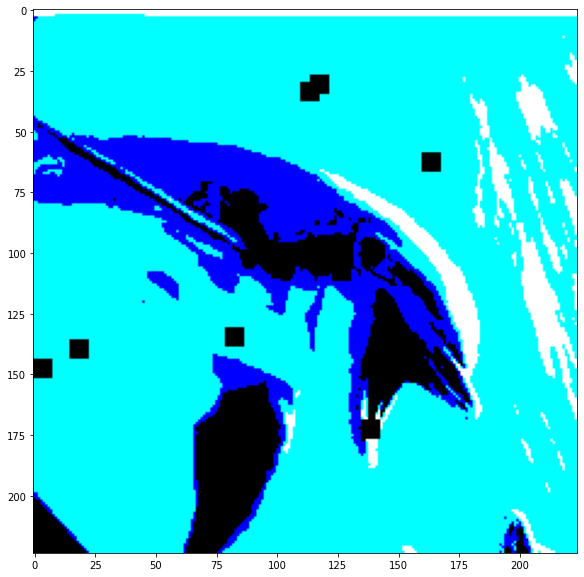

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

grid = gridspec.GridSpec(1,1)#그래프를 그릴 도화지 개수
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace= 0.4, hspace=0.4) #그래프 간의 거리 조절

ax0 = plt.subplot(grid[0])
ax0.imshow(img_to_c_arr)


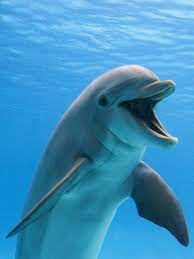

In [20]:
from PIL import Image as PILImage
PILImage.open(train_class.all_data[0])

In [21]:
# numpy == H W C
# tensor = C H W